Progetto di Linguistica Computazionale di Giacomo Fidone (531668) –  Confronto di due corpora

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, movie_reviews

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
sns.set_style('whitegrid') # stile dei plot

# Addestramento del classificatore del sentiment

In [4]:
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

In [5]:
pos_fileids = movie_reviews.fileids('pos')
neg_fileids = movie_reviews.fileids('neg')

In [6]:
# accedo ai file

pos_reviews = [movie_reviews.raw(fileid) for fileid in pos_fileids]
neg_reviews = [movie_reviews.raw(fileid) for fileid in neg_fileids]

In [7]:
# unisco i dati e genero le labels

reviews = pos_reviews + neg_reviews
labels = [1] * len(pos_reviews) + [0] * len(neg_reviews)

In [8]:
# divido train e test

X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, shuffle=True, random_state=42)

In [9]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

1600 1600
400 400


In [10]:
# inizializzo il modello ed il vectorizer

vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, max_features=3000)
clf = SVC()

In [11]:
# inizializzo la pipeline

pipe = Pipeline([
    ('tfidf-vectorizer', vectorizer),
    ('multinomialNB', clf)
])

In [12]:
# addestro il classifier

pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf-vectorizer',
                 TfidfVectorizer(max_features=3000,
                                 tokenizer=<function word_tokenize at 0x7bc0b45dca60>)),
                ('multinomialNB', SVC())])

In [13]:
y_pred = pipe.predict(X_test)

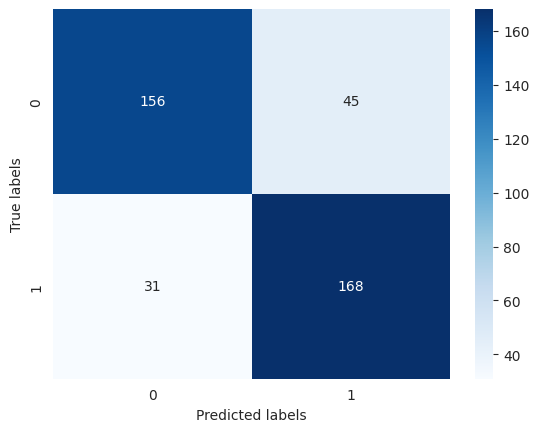

In [14]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [15]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.834     0.776     0.804       201
           1      0.789     0.844     0.816       199

    accuracy                          0.810       400
   macro avg      0.811     0.810     0.810       400
weighted avg      0.812     0.810     0.810       400



# Confronto di due testi

In [16]:
class Compare:

    def __init__(self, *args):
        '''Definisce un oggetto per il confronto di due o più testi. *args richiede i path ai testi da confrontare.'''

        self.path = args
        self.text = dict() # creo dizionari per salvare i testi, le frasi, le frasi tokenizzate, i token, le POS e le POS esclusa la punteggiatura di ciascun file
        self.sents = dict()
        self.tokenized_sents = dict()
        self.tokens = dict()
        self.pos = dict()
        self.pos_no_punct = dict()

        for path in self.path: # itero su ciascun path per salvare i testi, le frasi, le frasi tokenizzate, i token, le POS e le POS esclusa punteggiatura nei rispettivi dizionari
            self.text[path] = self.read_file(path)
            self.sents[path] = nltk.tokenize.sent_tokenize(self.text[path])
            self.tokenized_sents[path] = [nltk.word_tokenize(sent) for sent in self.sents[path]]
            self.tokens[path] = [token for sent in self.tokenized_sents[path] for token in sent]
            self.pos[path] = nltk.tag.pos_tag(self.tokens[path])
            penn_punct_pos =  ['.', ',', ':', '(', ')', '\'', '"'] # pos tags di Penn treebank per la punteggiatura
            self.pos_no_punct[path] = [(token, pos) for token, pos in self.pos[path] if pos not in penn_punct_pos]

    def compare_length(self):
        '''Confronta il numero di frasi ed il numero di token dei testi.'''

        for path in self.path: # itero su ciascun path per accedere alle frasi e ai token e calcolarne il numero
            num_sents = len(self.sents[path])
            num_tokens = len(self.tokens[path])

            print('Testo:', path)
            print(f'Numero di frasi: {num_sents}\tNumero di token: {num_tokens}.\n')

    def compare_avg_length(self):
        '''Confronta la lunghezza media delle frasi in token e dei token (punteggiatura esclusa) in caratteri.'''

        for path in self.path:
            sent_lens = [len(sent) for sent in self.tokenized_sents[path]] # lunghezze delle frasi in token
            avg_sent_len = round(sum(sent_lens) / len(sent_lens), 3) # lunghezza media

            token_lens = [len(token) for token, pos in self.pos_no_punct[path]] # lunghezze dei token (punteggiatura esclusa)
            avg_token_len = round(sum(token_lens) / len(token_lens), 3) # lunghezza media

            print(f'Testo: {path}')
            print(f'Lunghezza media delle frasi in token: {avg_sent_len}\tLunghezza media dei token (punteggiatura esclusa) in caratteri: {avg_token_len}.\n')

    def compare_hapax(self):
        '''Confronta gli hapax dei testi per porzioni incrementali (500, 1000, 3000 e tutti i token) di testo.'''

        hapax_dicts = dict() # dizionario per memorizzare (per ciascun testo) un dizionario della forma {upper_bound:num_hapax} funzionale alla generazione del grafico

        for path, tokens in self.tokens.items(): # itero sui token di ciascun testo
            print('Testo:', path)
            hapax_dict = dict() # dizionario per memorizzare il numero di hapax per ogni upper_bound
            max_length = len(tokens)

            for upper_bound in [500, 1000, 3000, max_length]:
                text_slice = tokens[:upper_bound]
                num_hapax = len(self.get_hapax(text_slice))
                if upper_bound == max_length: # per la generazione del grafico, riconduco le max_length ad un'unica etichetta
                    hapax_dict['tutti i token'] = num_hapax
                else:
                    hapax_dict[upper_bound] = num_hapax
                print(f'Upper bound: {upper_bound}\t Numero di hapax: {num_hapax}')

            print('')
            hapax_dicts[path] = hapax_dict

        data = pd.DataFrame(hapax_dicts) # converto in pandas DataFrame per semplificare la generazione del grafico
        data.plot()
        plt.title('Numero di hapax nei primi 500, 1000, 3000 token e su tutto il testo')
        plt.xlabel('Upper bound')
        plt.ylabel('Numero di hapax')
        plt.show()

    def compare_vocabulary(self):
        '''Confronta le dimensioni del vocabolario dei testi per porzioni incrementali (200 token) di testo.'''

        voc_dicts = dict()

        for path, tokens in self.tokens.items():
            print('Testo:', path)
            voc_dict = dict()
            max_length = len(tokens)
            upper_bound = 0 # inizializzo upper_bound

            while upper_bound < max_length:
                upper_bound += 200 # update dell'upper_bound
                if upper_bound > max_length: # riconduco l'upper_bound a max_length se l'update genera un upper_bound maggiore di max_length
                    upper_bound = max_length
                text_slice = tokens[:upper_bound]
                len_voc = len(list(set(text_slice)))
                voc_dict[upper_bound] = len_voc
                print(f'Upper bound: {upper_bound}\tDimensione del vocabolario: {len_voc}')

            print('')
            voc_dicts[path] = voc_dict

        data = pd.DataFrame(voc_dicts)
        data.plot()
        plt.title('Dimensione del vocabolario per porzioni incrementali di testo (200 token)')
        plt.xlabel('Upper bound')
        plt.ylabel('Dimensione del vocabolario')
        plt.show()

    def compare_ttr(self):
        '''Confronta la Type-Token Ratio dei testi per porzioni incrementali (200 token) di testo.'''

        ttr_dicts = dict() # il codice è analogo a quello implementato per compare_vocabulary()

        for path, tokens in self.tokens.items():
            print('Testo:', path)
            ttr_dict = dict()
            max_length = len(tokens)
            upper_bound = 0

            while upper_bound < max_length:
                upper_bound += 200
                if upper_bound > max_length:
                    upper_bound = max_length
                text_slice = tokens[:upper_bound]
                ttr = len(list(set(text_slice))) / len(text_slice)
                ttr_dict[upper_bound] = ttr
                print(f'Upper bound: {upper_bound}\tType-Token Ratio: {round(ttr, 3)}')

            print('')
            ttr_dicts[path] = ttr_dict

        data = pd.DataFrame(ttr_dicts)
        data.plot()
        plt.title('Type-Token Ratio per porzioni incrementali di testo (200 token)')
        plt.xlabel('Upper bound')
        plt.ylabel('Type-Token Ratio')
        plt.show()

    def compare_lemmas(self):
        '''Confronta il numero di lemmi distinti dei testi.'''

        lemmatizer = WordNetLemmatizer() # inizializzo il lemmatizzatore

        for path in self.path: # lemmatizzo ogni token passando in input al lemmatizzatore sia il token che la pos di wordnet. Escludo la punteggiatura
            lemmas = [lemmatizer.lemmatize(token, self.get_wordnet_pos(pos)) for token, pos in self.pos_no_punct[path]]
            num_unique_lemmas = len(list(set(lemmas)))
            print(f'Testo: {path}')
            print(f'Numero di lemmi distinti: {num_unique_lemmas}\n')

    def compare_sentiment(self):
        '''Confronta i testi rispetto alla distribuzione di frasi con polarità positiva e negativa. Il metodo utilizza il
        classificatore addestrato nella sezione precedente.'''

        sentiment_dicts = dict() # dizionario per memorizzare (per ciascun testo) un dizionario della forma {classe:numero di frasi}

        for path, sents in self.sents.items(): # itero sulle frasi di ciascun testo
            sentiment_dict = dict() # dizionario della forma {classe:numero di frasi}
            y_pred = pipe.predict(sents) # uso la pipeline per generare le predizioni
            labels, counts = np.unique(y_pred, return_counts=True) # conto il numero di predizioni di ciascuna classe
            labels = np.where(labels == 0, 'sentiment negativo', 'sentiment positivo') # sostitusco le classi (numeriche) con stringhe interpretabili
            print('Text:', path)
            for label, count in zip(labels, counts): # itero su ciascuna classe e corrispondente numero di predizioni
                freq = count / len(y_pred) # calcolo la frequenza relativa di ciascuna classe rispetto al totale delle predizioni
                sentiment_dict[label] = freq
                print(f'Frazione di frasi con {label}: {round(freq, 3)}')

            print('')
            sentiment_dicts[path] = sentiment_dict

        data = pd.DataFrame(sentiment_dicts)
        data.plot(kind='barh')
        plt.title('')
        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(0, 1)
        plt.show()

    @staticmethod
    def read_file(path_to_file):
        '''Apre un file e lo restituisce come stringa.'''

        with open(path_to_file, 'r', encoding='utf-8') as infile:
            return infile.read()

    @staticmethod
    def get_hapax(tokens):
        '''Restituisce gli hapax di una lista di token.'''

        return [token for token in list(set(tokens)) if tokens.count(token) == 1]

    @staticmethod
    def get_wordnet_pos(treebank_tag):
        '''Converte la POS di Penn Treebank nella POS di Wordnet.'''

        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        if treebank_tag.startswith('V'):
            return wordnet.VERB
        if treebank_tag.startswith('N'):
            return wordnet.NOUN
        if treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

In [17]:
compare = Compare('animal_farm.txt', 'constitution_of_the_united_states.txt')

In [18]:
compare.compare_length()

Testo: animal_farm.txt
Numero di frasi: 1640	Numero di token: 34453.

Testo: constitution_of_the_united_states.txt
Numero di frasi: 440	Numero di token: 20283.



In [19]:
compare.compare_avg_length()

Testo: animal_farm.txt
Lunghezza media delle frasi in token: 21.008	Lunghezza media dei token (punteggiatura esclusa) in caratteri: 4.394.

Testo: constitution_of_the_united_states.txt
Lunghezza media delle frasi in token: 46.098	Lunghezza media dei token (punteggiatura esclusa) in caratteri: 4.794.



Testo: animal_farm.txt
Upper bound: 500	 Numero di hapax: 188
Upper bound: 1000	 Numero di hapax: 296
Upper bound: 3000	 Numero di hapax: 563
Upper bound: 34453	 Numero di hapax: 2171

Testo: constitution_of_the_united_states.txt
Upper bound: 500	 Numero di hapax: 166
Upper bound: 1000	 Numero di hapax: 226
Upper bound: 3000	 Numero di hapax: 368
Upper bound: 20283	 Numero di hapax: 959



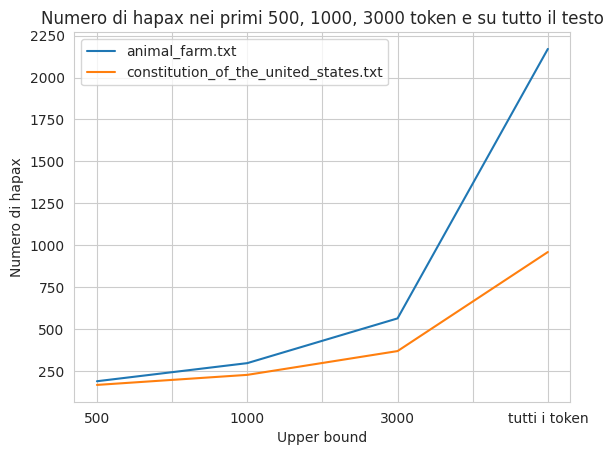

In [20]:
compare.compare_hapax()

Testo: animal_farm.txt
Upper bound: 200	Dimensione del vocabolario: 117
Upper bound: 400	Dimensione del vocabolario: 211
Upper bound: 600	Dimensione del vocabolario: 290
Upper bound: 800	Dimensione del vocabolario: 360
Upper bound: 1000	Dimensione del vocabolario: 426
Upper bound: 1200	Dimensione del vocabolario: 494
Upper bound: 1400	Dimensione del vocabolario: 556
Upper bound: 1600	Dimensione del vocabolario: 602
Upper bound: 1800	Dimensione del vocabolario: 650
Upper bound: 2000	Dimensione del vocabolario: 696
Upper bound: 2200	Dimensione del vocabolario: 735
Upper bound: 2400	Dimensione del vocabolario: 780
Upper bound: 2600	Dimensione del vocabolario: 809
Upper bound: 2800	Dimensione del vocabolario: 866
Upper bound: 3000	Dimensione del vocabolario: 901
Upper bound: 3200	Dimensione del vocabolario: 949
Upper bound: 3400	Dimensione del vocabolario: 994
Upper bound: 3600	Dimensione del vocabolario: 1026
Upper bound: 3800	Dimensione del vocabolario: 1059
Upper bound: 4000	Dimensione 

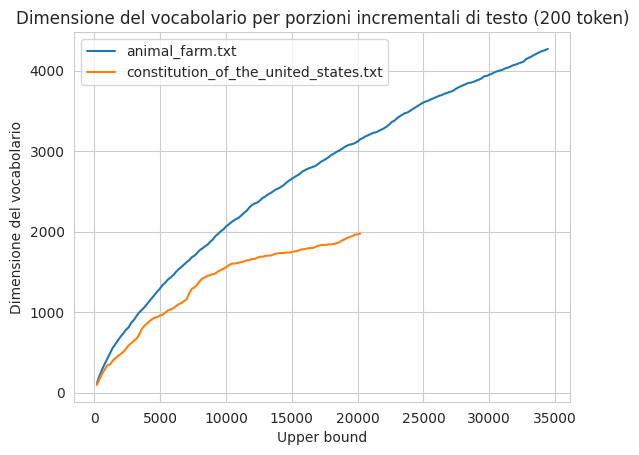

In [21]:
compare.compare_vocabulary()

Testo: animal_farm.txt
Upper bound: 200	Type-Token Ratio: 0.585
Upper bound: 400	Type-Token Ratio: 0.527
Upper bound: 600	Type-Token Ratio: 0.483
Upper bound: 800	Type-Token Ratio: 0.45
Upper bound: 1000	Type-Token Ratio: 0.426
Upper bound: 1200	Type-Token Ratio: 0.412
Upper bound: 1400	Type-Token Ratio: 0.397
Upper bound: 1600	Type-Token Ratio: 0.376
Upper bound: 1800	Type-Token Ratio: 0.361
Upper bound: 2000	Type-Token Ratio: 0.348
Upper bound: 2200	Type-Token Ratio: 0.334
Upper bound: 2400	Type-Token Ratio: 0.325
Upper bound: 2600	Type-Token Ratio: 0.311
Upper bound: 2800	Type-Token Ratio: 0.309
Upper bound: 3000	Type-Token Ratio: 0.3
Upper bound: 3200	Type-Token Ratio: 0.297
Upper bound: 3400	Type-Token Ratio: 0.292
Upper bound: 3600	Type-Token Ratio: 0.285
Upper bound: 3800	Type-Token Ratio: 0.279
Upper bound: 4000	Type-Token Ratio: 0.275
Upper bound: 4200	Type-Token Ratio: 0.272
Upper bound: 4400	Type-Token Ratio: 0.268
Upper bound: 4600	Type-Token Ratio: 0.265
Upper bound: 4800	

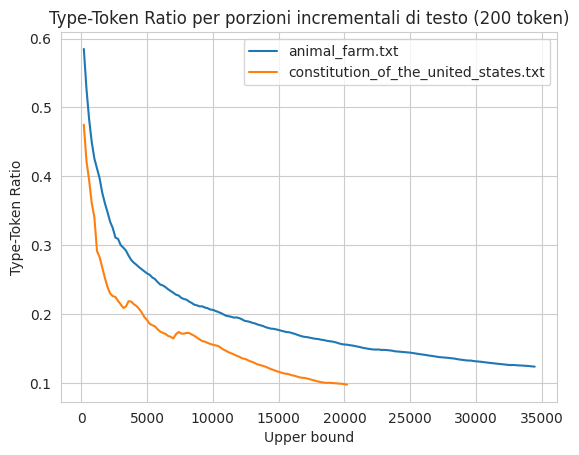

In [22]:
compare.compare_ttr()

In [23]:
compare.compare_lemmas()

Testo: animal_farm.txt
Numero di lemmi distinti: 3479

Testo: constitution_of_the_united_states.txt
Numero di lemmi distinti: 1801



Text: animal_farm.txt
Frazione di frasi con sentiment negativo: 0.679
Frazione di frasi con sentiment positivo: 0.321

Text: constitution_of_the_united_states.txt
Frazione di frasi con sentiment negativo: 0.568
Frazione di frasi con sentiment positivo: 0.432



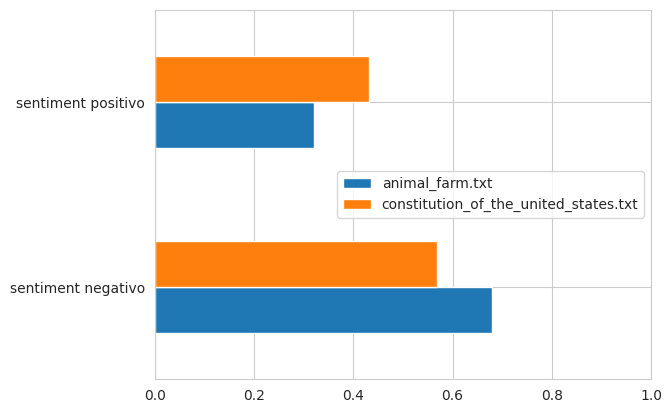

In [24]:
compare.compare_sentiment()